# FIT5196 Task 4 in Assessment 2
#### Student Name: Boyu Zhang
#### Student ID: 28491300

Date: XX/XX/XXXX

Version: 1.0

Environment: Python 3.6 and Jupyter notebook

Libraries used: please include the main libraries you used in your assignment here, e.g.,:
* pandas (for dataframe, included in Anaconda Python ) 
* re (for regular expression, included in Anaconda Python 3.6) 
* numpy (for numpy array, included in Anaconda Python 3.6) 
* sklearn (for machine learning algorithm, obtained with `conda install scikit-learn`)

## 1.  Import libraries 

In [1]:
# Code to import libraries as you need in this assessment, e.g.,
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 2. Load data and exploration


In [2]:
df4 = pd.read_csv('./Input/dataset4_with_outliers.csv')

In [3]:
df4.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,5437400630,20141016T000000,625000.0,4,2.25,1920,8259,2.0,0,0,4,8,1920,0,1979,0,98027,47.5616,-122.088
1,3999300290,20141016T000000,850000.0,3,3.50,2620,11148,2.0,0,4,4,9,2060,560,1977,0,98008,47.5845,-122.115
2,2525059134,20141016T000000,500000.0,2,1.50,1760,12000,1.0,0,0,4,7,1760,0,1964,0,98052,47.6288,-122.109
3,1862400285,20141016T000000,375000.0,3,1.00,1200,5404,1.0,0,0,3,6,1200,0,1937,0,98117,47.6969,-122.368
4,7199320190,20141016T000000,618000.0,4,2.25,2470,7350,1.0,0,0,3,7,1600,870,1978,0,98052,47.6936,-122.128


In [4]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 19 columns):
id               9996 non-null int64
date             9996 non-null object
price            9996 non-null float64
bedrooms         9996 non-null int64
bathrooms        9996 non-null float64
sqft_living      9996 non-null int64
sqft_lot         9996 non-null int64
floors           9996 non-null float64
waterfront       9996 non-null int64
view             9996 non-null int64
condition        9996 non-null int64
grade            9996 non-null int64
sqft_above       9996 non-null int64
sqft_basement    9996 non-null int64
yr_built         9996 non-null int64
yr_renovated     9996 non-null int64
zipcode          9996 non-null int64
lat              9996 non-null float64
long             9996 non-null float64
dtypes: float64(5), int64(13), object(1)
memory usage: 1.4+ MB


## 2. Naive feature selection

- We propose to use cluster model to detect the outliers
- We represent each record as a point in high-dimension space
- Thus, we need to elinamet some features that will certainly cause errors.

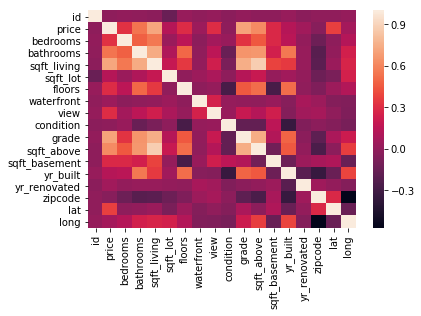

In [5]:
#heatmap to reveal correlation between features
sns.heatmap(df4.corr());

### Reasoning
- The heatmap above shows some features are poorly related to all other features
- `id` is just a unique identification for each record, should not be used to 
- `date` is categorical data thus cannot be represented in coordinate, need to be dropped
- `zipcode`directly indicates the range of `lat` and `long` , it is reasonable to think the location have certain level of impact on the price as well as other features, so we only keep `zipcode`but not `lat` and `long`
- `yr_renovated`and `waterfront` are so pooly related to almost all features that we can drop them.

So we use the remaining 13 columns to find the outliers

## 3. Method selection
- We know that quite a few of the features are correlated but we don't know the exact correlation
- With boxplot we can only determine the outliers based on statics of this single feature, however feautures are correlated so this is not acceptable
### Desion
We choose a cluster model which is suitable for moderately large dataset, which is the `Local Outlier Factor` 

### LOF explained
- To be precise, locality is given by k-nearest neighbors, whose distance is used to predict the local density. By comparing the local density of a sample to the local densities of its neighbors, samples that have a substantially lower density than their neighbors can be considered outliers.
- **This means** if the feature of a record is quite different from the records with a similar pattern to it, the local density of point representing the record will be lower, in this way we try to identify the outliers.

In [6]:
X = df4.drop(columns=['id','date','yr_renovated','waterfront','lat','long'])

- Here we need to determine the optimal **K** for the KNN queries, so that the model can perform the best
- Sicnce the LOF model doesn't support Cross-validation for it has no score suitable method, we just use the convention that `k = sqrt(n)`

In [7]:
k = sqrt(df4.shape[0])

To use this model, it is necessary we also give an estimate of the propotion of contamination

ValueError: not enough values to unpack (expected 2, got 1)

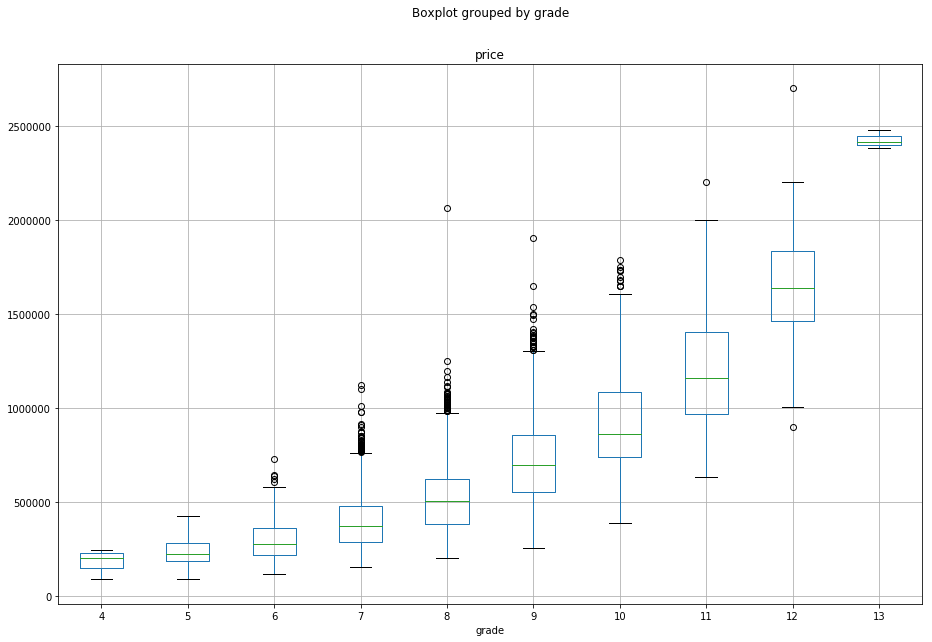

In [11]:
# get outliers of each single feature according to the boxplot
_, bp = X.boxplot(column='price',by='grade',figsize=(15,10),return_type='both');
outliers = []
for flier in bp["fliers"]:
    outliers.append(list(flier.get_ydata()))

In [35]:
# compute the mean number of outliers for all featuers
outlier_no = []
for l in outliers:
    outlier_no.append(len(l))

In [37]:
pd.DataFrame(np.array(outlier_no).reshape(1,13),columns=df4.drop(columns=['id','date','yr_renovated','waterfront','lat','long']).columns)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode
0,371,218,80,223,1111,0,864,11,740,267,271,0,0


### Reasoning
- The most number of single feature outliers concentrate in `sqft_living`,`grade`,`view`.
- However, `grade` and `view` is rating features that can be quite subjective, a seemingly inrational rating should be recognized as an outlier

**So we use the mean number of outliers as the contamination ratio to train our model**

In [18]:
mean = sum(outlier_no)/len(outlier_no)
ratio = mean/df4.shape[0]

Since this is a high dimention space, we are not able to visualize it.

In [19]:
lof =  LocalOutlierFactor(int(k),n_jobs=-1,p=13,contamination=ratio)

In [20]:
df4['is_outlier'] = lof.fit_predict(X)

In [21]:
#inspect the records that are identified as outliers
df4[df4.is_outlier == -1].sqft_lot.mean()

81417.071875

In [22]:
df4.sqft_lot.mean()

15472.810724289717

Now we eliminate the outliers detected

In [23]:
df4 = df4[~(df4.is_outlier == -1)]

In [ ]:
df4.drop(columns='is_outlier',inplace=True)

In [ ]:
df4.to_csv('./dataset4_solution.csv',index=False)

## 3. Summary
Give a short summary of your work done above, such as your findings.

### Reference
1. Local outlier factor. Retrieved from:http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
2. How to get data from pandas boxplot? Retrieved from: https://stackoverflow.com/questions/33518472/getting-data-of-a-boxplot-pandas